# Description

* Comparing the relative abundances of taxa with and without incorporation.
  * log-ratios
  * Deseq2
* Total number amplicon fragments:
  * 2e9
* Subsampling size:
  * Variable to see how sampling depth affects log ratios

# Init

In [211]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome_all/nl2/inc0_v_inc10/'
copyDir = '/home/nick/notebook/SIPSim/dev/bac_genome_all/nl1/fragLen/'
baseDir = '/home/nick/notebook/SIPSim/dev/bac_genome_all/'
SIPSimExe = '/home/nick/notebook/SIPSim/SIPSim'

In [212]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [213]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(data.table)

In [214]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)
os.chdir(workDir)

# Simulating gradient communities

In [215]:
!cd $workDir; \
    $SIPSimExe gradientComms \
    --n_comm 2 \
    --abund_dist lognormal \
    --abund_dist_p mean:10,sigma:2 \
    $baseDir/genomes/taxon_index.txt > comm-n2-logn.txt
    
!cd $workDir; tail comm-n2-logn.txt

2	Sphaerochaeta_globosa_str_Buddy	0.000092916	1201
2	Streptosporangium_roseum_DSM_43021	0.000091566	1202
2	Mycoplasma_synoviae_53	0.000072170	1203
2	Prevotella_ruminicola_23	0.000065109	1204
2	Pasteurella_multocida_subsp_multocida_str_HN06	0.000049742	1205
2	Streptomyces_hygroscopicus_subsp_jinggangensis_5008	0.000042714	1206
2	Sulfurospirillum_barnesii_SES-3	0.000038186	1207
2	Shigella_flexneri_Shi06HN006	0.000034088	1208
2	Achromobacter_xylosoxidans_A8	0.000020129	1209
2	Pseudomonas_syringae_pv_syringae_B728a	0.000002049	1210


[1] 200
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000002  0.002478  0.009161  0.082640  0.034740 16.370000 
[1] 7988383


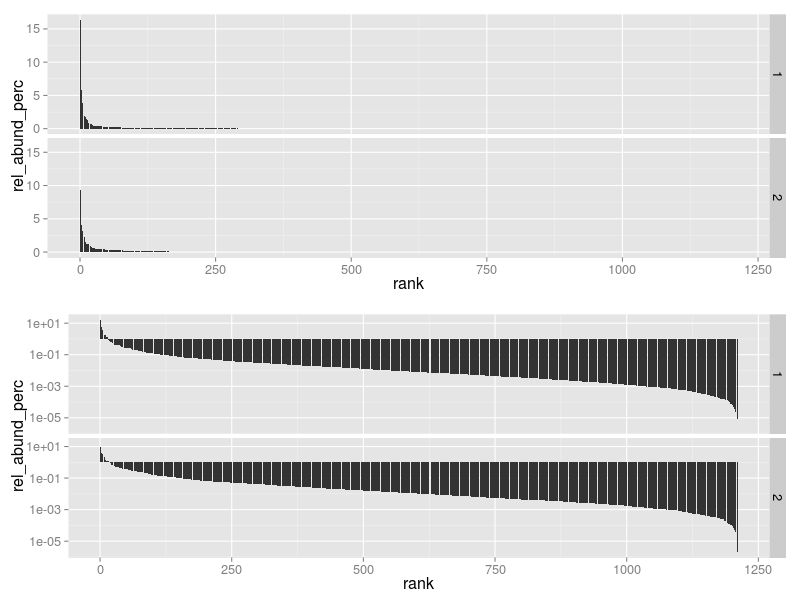

In [216]:
%%R -i workDir -w 800 -h 600 
# plotting the abundance distribution
setwd(workDir)

tbl = read.delim('comm-n2-logn.txt', sep='\t')

print(sum(tbl$rel_abund_perc))
print(summary(tbl$rel_abund_perc))
print(max(tbl$rel_abund_perc) / min(tbl$rel_abund_perc))


# plotting
p1 = ggplot(tbl, aes(rank, rel_abund_perc)) +
    geom_bar(stat='identity') +
    facet_grid(library ~ .) +
    theme( text = element_text(size=16))

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=1)

# Simulating isotope incorporation

In [234]:
# making config file
config = """
[library 1]
  # baseline: no incorp
  
  [[intraPopDist 1]]
  distribution = uniform

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0
        
[library 2]
  # split inter-pop distribution (~10% of taxa have ~100% incorp)
  
  [[intraPopDist 1]]
  distribution = normal

    [[[mu]]]

      # these taxa get full incorp
      [[[[interPopDist 1]]]]
        weight = 0.1
        distribution = uniform
        start = 100
        end = 100

      # these taxa in the community get no incorp
      [[[[interPopDist 2]]]]
        weight = 0.9      
        distribution = uniform
        start = 0
        end = 0

    [[[sigma]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0
        
"""

outfile = os.path.join(workDir, 'incorp.config')

outf = open(outfile, 'wb')
outf.write(config)
outf.close()

In [246]:
!cd $workDir; \
     $SIPSimExe isoIncorp \
    comm-n2-logn.txt incorp.config \
    > incorp-n2-logn.txt
    
!cd $workDir; head incorp-n2-logn.txt
!cd $workDir; tail incorp-n2-logn.txt

library	taxon_name	distribution_index	distribution	weight	param	param_value
1	Blattabacterium_sp_Blattella_germanica_str_Bge	1	uniform	1.0	start	0.0
1	Blattabacterium_sp_Blattella_germanica_str_Bge	1	uniform	1.0	end	0.0
1	Neisseria_lactamica_020-06	1	uniform	1.0	start	0.0
1	Neisseria_lactamica_020-06	1	uniform	1.0	end	0.0
1	Bacillus_amyloliquefaciens_SQR9	1	uniform	1.0	start	0.0
1	Bacillus_amyloliquefaciens_SQR9	1	uniform	1.0	end	0.0
1	Echinicola_vietnamensis_DSM_17526	1	uniform	1.0	start	0.0
1	Echinicola_vietnamensis_DSM_17526	1	uniform	1.0	end	0.0
1	Collimonas_fungivorans_Ter331	1	uniform	1.0	start	0.0
2	Spiroplasma_culicicola_AES-1	1	normal	1.0	mu	0.0
2	Spiroplasma_culicicola_AES-1	1	normal	1.0	sigma	7.93745197663e-11
2	Parachlamydia_acanthamoebae_UV-7	1	normal	1.0	mu	0.0
2	Parachlamydia_acanthamoebae_UV-7	1	normal	1.0	sigma	9.22315650128e-13
2	Caldicellulosiruptor_obsidiansis_OB47	1	normal	1.0	mu	0.0
2	Caldicellulosiruptor_obsidiansis_OB47	1	normal	1.0	sigma	5.5089429744e-11
2	Leuc

In [248]:
%%R
# plotting incorp
tbl.incorp = read.delim('incorp-n2-logn.txt', sep='\t')

ggplot(tbl.incorp, aes(param, param_value)) +
    geom_violin() +
    geom_point() +
    facet_grid(library ~ .)


## quanifying number of taxa with mu > 90
n_taxa = tbl.incorp %>% filter(library == 2) %>% distinct(taxon_name) %>% nrow 
message('Number of taxa: ', n_taxa)
n_taxa_mu90 = tbl.incorp %>% filter(library == 2, param == 'mu', param_value > 90) %>% nrow 
message('Number of taxa with mu > 90: ', n_taxa_mu90)
message('Percent taxa with mu > 90: ', round(n_taxa_mu90 / n_taxa * 100, digits=1), '%')

Number of taxa: 1210
Number of taxa with mu > 90: 123
Percent taxa with mu > 90: 10.2%


# Simulating gradient fractions

In [249]:
!cd $workDir; \
    $SIPSimExe fractions \
    comm-n2-logn.txt \
    > fracs-n2-logn.txt
    
!cd $workDir; head fracs-n2-logn.txt
!cd $workDir; tail fracs-n2-logn.txt

library	fraction	BD_min	BD_max	fraction_size
1	1	1.66	1.663	0.003
1	2	1.663	1.666	0.003
1	3	1.666	1.67	0.004
1	4	1.67	1.674	0.004
1	5	1.674	1.679	0.005
1	6	1.679	1.683	0.004
1	7	1.683	1.686	0.003
1	8	1.686	1.69	0.004
1	9	1.69	1.692	0.002
2	25	1.758	1.764	0.006
2	26	1.764	1.766	0.002
2	27	1.766	1.771	0.005
2	28	1.771	1.773	0.002
2	29	1.773	1.776	0.003
2	30	1.776	1.78	0.004
2	31	1.78	1.786	0.006
2	32	1.786	1.788	0.002
2	33	1.788	1.789	0.001
2	34	1.789	1.795	0.006


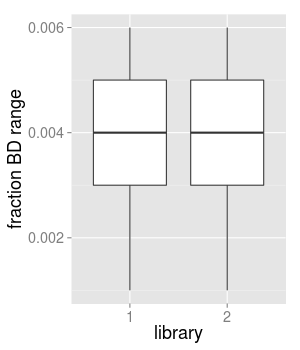

In [250]:
%%R -i workDir -h 350 -w 300 
# plotting the abundance distribution
setwd(workDir)

tbl = read.delim('fracs-n2-logn.txt', sep='\t')
tbl$library = as.character(tbl$library)


ggplot(tbl, aes(library, fraction_size)) +
    geom_boxplot() +
    labs(y='fraction BD range') +
    theme( 
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
    )

# Simulating amplicon fragments & calculating GC

## Skewed-normal fragment length distribution 

* default params 
  * I'm explicitly setting the defaults in case they change later
  * no real size restrictions on frag length

In [92]:
!cd $workDir;\
    $SIPSimExe fragGC \
    $baseDir/genomes/genome_index.txt \
    --fp $baseDir/genomes/ \
    --fr $baseDir/515Fm-927Rm.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr 500,None \
    --nf 10000 \
    --np 24 \
    2> ampFragGC_skewN90-25-n5-nS.log \
    > ampFragGC_skewN90-25-n5-nS.pkl

## Creating OTU table

In [ ]:
!cd $workDir; \
    $SIPSimExe OTU_sim \
    ampFragGC_skewN90-25-n5-nS.pkl \
    comm-n2-logn.txt \
    incorp-n2-logn.txt \
    fracs-n2-logn.txt \
    --abs_abund 2e9 \
    2> OTU-n1-logn_skewN90-25-n5-nS_A2e9.log \
    > OTU-n1-logn_skewN90-25-n5-nS_A2e9.txt

## Plotting OTU abundances

In [720]:
%%R -i workDir

# loading file
inFiles = c('OTU-n1-logn_skewN90-25-n5-nS_A2e9.txt')

inFiles = sapply(inFiles, function(x){
            paste(c(workDir, x), collapse='/')
    })

tbls = list()
for (fileName in names(inFiles)){
    tbls[[fileName]] = read.csv(fileName, sep='\t')
    }
tbl = do.call(rbind, tbls)
tbl$abs_abund = as.numeric(gsub('.+-nS_A|\\.txt\\.[0-9]+', '', rownames(tbl)))

tbl = tbl %>% 
    filter(!grepl('inf', fractions, ignore.case=T)) %>%
    separate(fractions, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%
    filter(BD_min != 1.795)

In [721]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

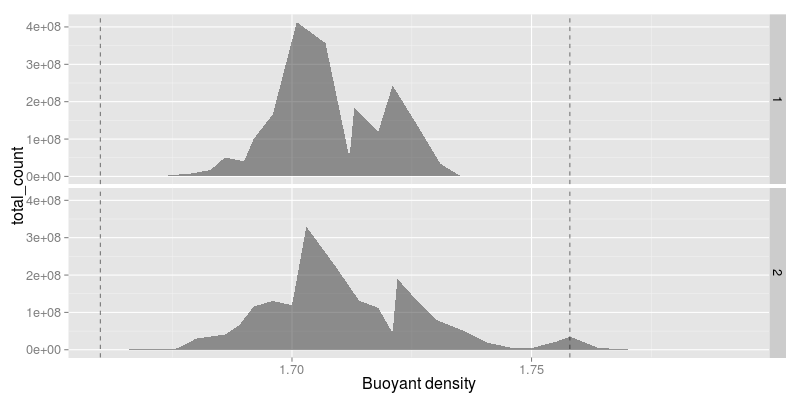

In [722]:
%%R -w 800 -h 400
# plotting absolute abundances

tbl.s = tbl %>%
    group_by(abs_abund, BD_min, library) %>%
    summarize(total_count = sum(count))


## plot
p = ggplot(tbl.s, aes(BD_min, total_count)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme( 
        text = element_text(size=16) 
    )
p

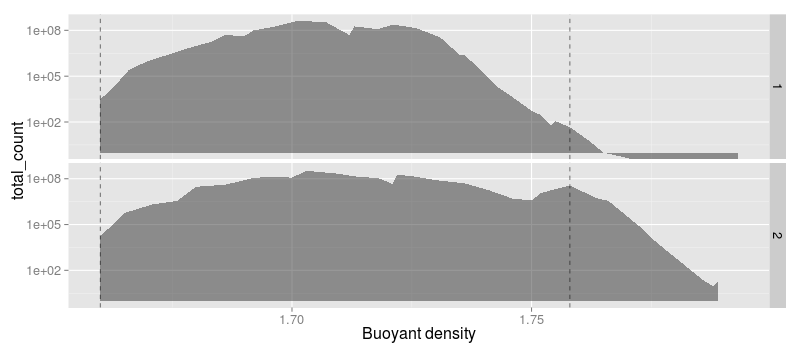

In [723]:
%%R -w 800 -h 350

p + scale_y_log10()

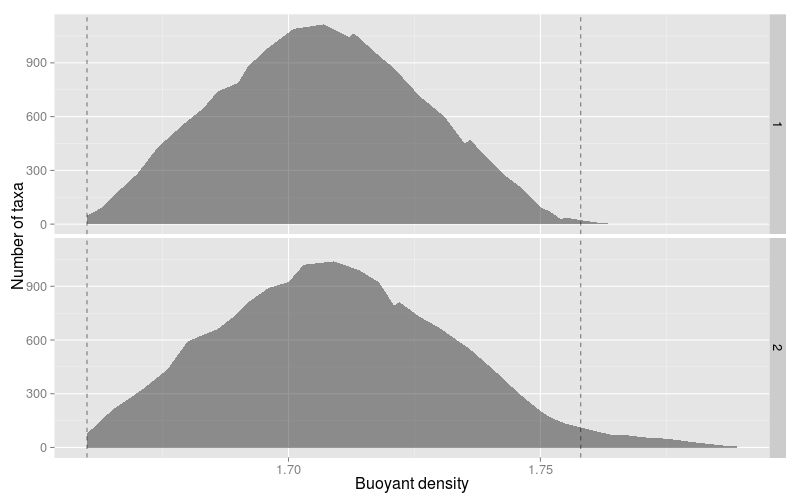

In [724]:
%%R -w 800 -h 500
# plotting number of taxa at each BD

tbl.nt = tbl %>%
    filter(count > 0) %>%
    group_by(library, abs_abund, BD_min) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(tbl.nt, aes(BD_min, n_taxa)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    facet_grid(library ~ .) +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

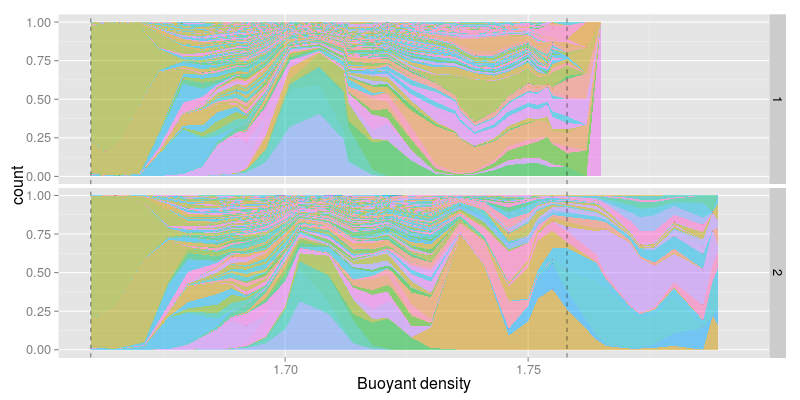

In [725]:
%%R -w 800 -h 400
# plotting relative abundances

## plot
p = ggplot(tbl, aes(BD_min, count, fill=taxon)) +
    geom_area(stat='identity', alpha=0.5, position='fill') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

In [726]:
%%R
# ordering taxa by total abundances
tax_order = tbl %>%
    group_by(taxon) %>%
    summarize(taxon_total_abund = sum(count)) %>%
    as.data.frame

tax_order = unique(tax_order[order(tax_order$taxon_total_abund, decreasing=T),'taxon']) 

tbl$taxon = factor(tbl$taxon, levels=sort(unique(tbl$taxon), decreasing=T))
tbl$taxon_group = factor(tbl$taxon, levels=tax_order)

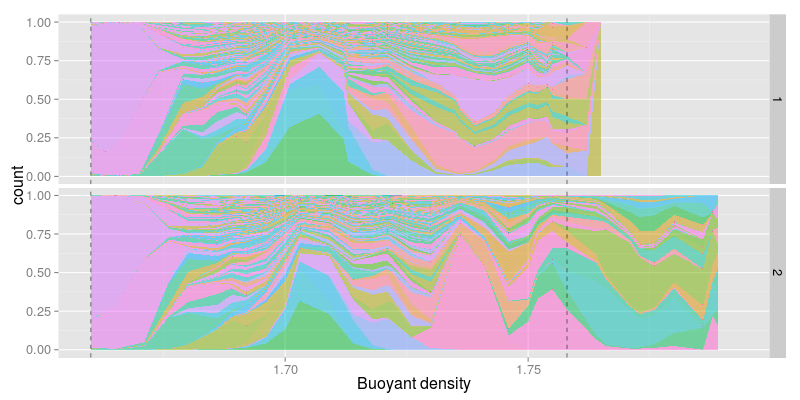

In [727]:
%%R -w 800 -h 400
# plotting relative abundances

## plot
p = ggplot(tbl, aes(BD_min, count, fill=taxon, order=taxon_group)) +
    geom_area(stat='identity', alpha=0.5, position='fill') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

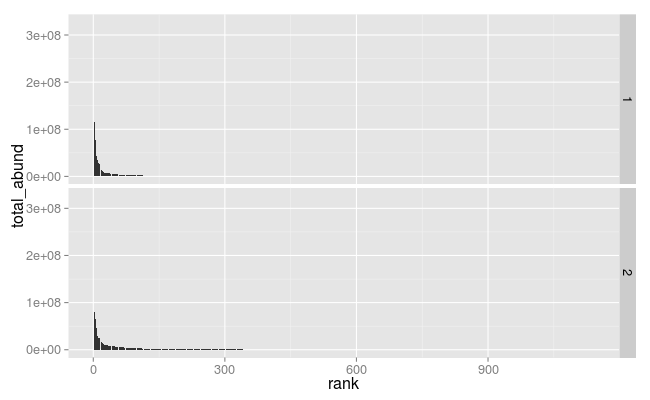

In [728]:
%%R -h 400 -w 650

tbl.s = tbl %>%
    group_by(library, abs_abund, taxon) %>%
    summarize( total_abund = sum(count) ) %>%
    mutate(rank = min_rank(desc(total_abund))) %>%
    arrange(rank)

ggplot(tbl.s, aes(rank, total_abund)) +
    geom_bar(stat='identity') +
    facet_grid(library ~ .) +
    theme( text = element_text(size=16))

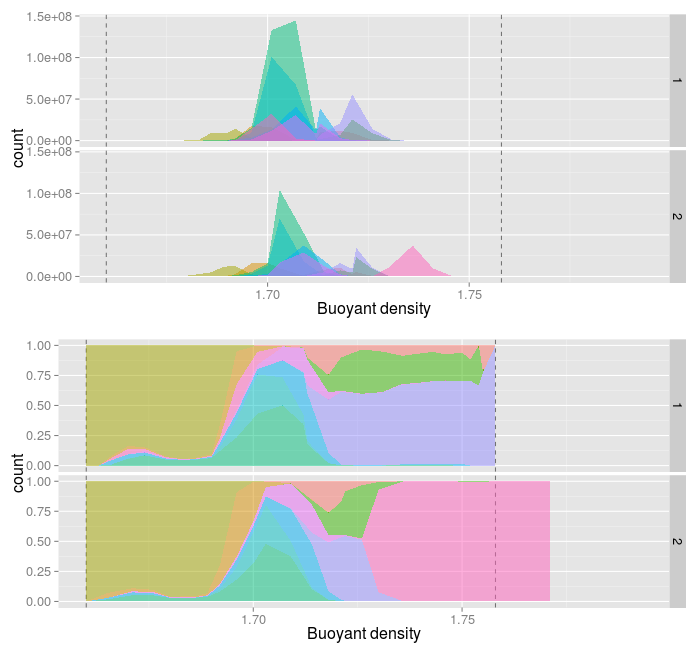

In [729]:
%%R -w 700 -h 650
# plotting most abundant taxa

tbl.s.a10 = tbl.s %>%
    filter(rank <= 10)

tbl.a10 = tbl %>%
    filter(taxon %in% tbl.s.a10$taxon)

## plot
p = ggplot(tbl.a10, aes(BD_min, count, fill=taxon, group=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p1 = p + geom_area(stat='identity', alpha=0.5, position='dodge') 
p2 = p + geom_area(stat='identity', alpha=0.5, position='fill') 

grid.arrange(p1, p2, ncol=1)


Call:
lm(formula = BD_range ~ log(total_abund), data = tbl.bdr)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.019315 -0.006673 -0.002837  0.002146  0.046433 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.0065601  0.0021870    3.00  0.00276 ** 
log(total_abund) 0.0041288  0.0001683   24.53  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01134 on 1139 degrees of freedom
Multiple R-squared:  0.3457,	Adjusted R-squared:  0.3452 
F-statistic: 601.9 on 1 and 1139 DF,  p-value: < 2.2e-16



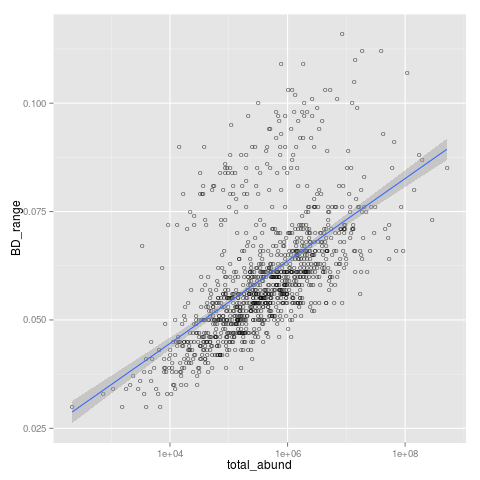

In [731]:
%%R

tbl.bdr = tbl %>%
    group_by(taxon) %>%
    filter(count > 0) %>%
    summarize(BD_range = max(BD_max) - min(BD_min),
              total_abund = sum(count))  

# linear regression
res = lm(BD_range ~ log(total_abund), tbl.bdr)
print(summary(res))

# plotting 
ggplot(tbl.bdr, aes(total_abund, BD_range)) +
    geom_point(alpha=0.75, shape='O') +
    geom_smooth(method='lm') +
    scale_x_log10()

# Plotting abundances of incorp taxa (vs control)

## Taxa that incorporated isotope

In [593]:
%%R
# plotting incorp
tbl.incorp = read.delim('incorp-n2-logn.txt', sep='\t')

## quanifying number of taxa 
n_taxa = tbl.incorp %>% filter(library == 2) %>% distinct(taxon_name) %>% nrow 
message('Number of taxa: ', n_taxa)
n_taxa_mu1 = tbl.incorp %>% filter(library == 2, param == 'mu', param_value > 1) %>% nrow 
message('Number of taxa with mu > 1: ', n_taxa_mu1)
message('Percent taxa with mu > 1: ', round(n_taxa_mu1 / n_taxa * 100, digits=1), '%')

Number of taxa: 1210
Number of taxa with mu > 1: 123
Percent taxa with mu > 1: 10.2%


In [594]:
%%R
taxa.incorp = tbl.incorp %>% 
    filter(library == 2, param == 'mu', param_value > 1) %>% 
    distinct(taxon_name) 

head(taxa.incorp)

  library                                             taxon_name
1       2                         Methylobacillus_flagellatus_KT
2       2 Cardinium_endosymbiont_cEper1_of_Encarsia_pergandiella
3       2                          Thiocystis_violascens_DSM_198
4       2        Campylobacter_fetus_subsp_venerealis_cfvi03_293
5       2     Blattabacterium_sp_Periplaneta_americana_str_BPLAN
6       2                          Salinispora_arenicola_CNS-205
  distribution_index distribution weight param param_value
1                  1       normal      1    mu         100
2                  1       normal      1    mu         100
3                  1       normal      1    mu         100
4                  1       normal      1    mu         100
5                  1       normal      1    mu         100
6                  1       normal      1    mu         100


## Plotting just incorporating taxa

In [595]:
%%R -i workDir

# loading file
inFiles = c('OTU-n1-logn_skewN90-25-n5-nS_A2e9.txt')

inFiles = sapply(inFiles, function(x){
            paste(c(workDir, x), collapse='/')
    })

tbls = list()
for (fileName in names(inFiles)){
    tbls[[fileName]] = read.csv(fileName, sep='\t')
    }
tbl = do.call(rbind, tbls)
tbl$abs_abund = as.numeric(gsub('.+-nS_A|\\.txt\\.[0-9]+', '', rownames(tbl)))

tbl = tbl %>% 
    filter(!grepl('inf', fractions, ignore.case=T)) %>%
    separate(fractions, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%
    filter(BD_min != 1.795)

In [596]:
%%R
# filtering to just incorporating taxa

tbl.incorp = tbl %>% 
    filter(taxon %in% taxa.incorp$taxon_name)

tbl.incorp %>% distinct(taxon) %>% nrow

[1] 123


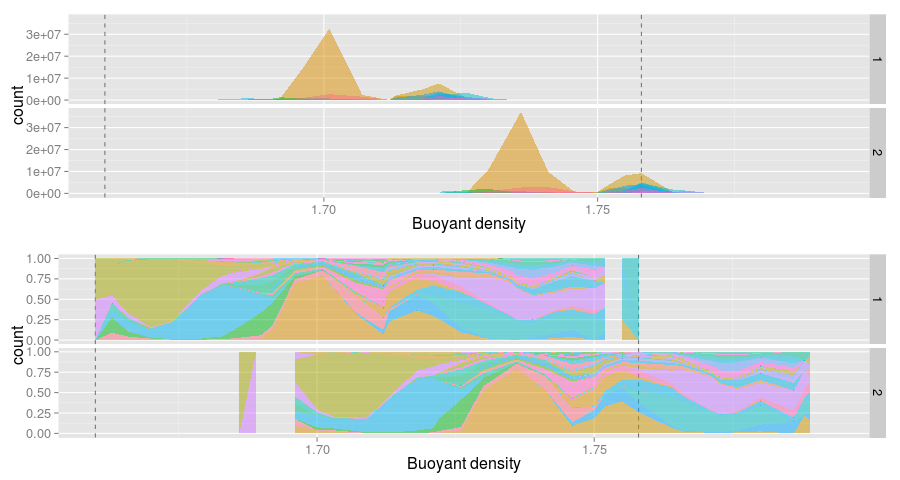

In [597]:
%%R -w 900
# plotting abundances

p = ggplot(tbl.incorp, aes(BD_min, count, fill=taxon, group=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p1 = p + geom_area(stat='identity', alpha=0.5, position='dodge') 
p2 = p + geom_area(stat='identity', alpha=0.5, position='fill') 

grid.arrange(p1, p2, ncol=1)

__Notes:__

* 'heavy' region (region that contains all isotopically enriched OTUs) range:
  * ~1.7 to ~1.785
* 12C-13C overlapping 'heavy' region:
  * ~1.7 to ~1.75

# Subsampling samples

* simulating sequencing from samples
* sampling with replacement

In [733]:
!cd $workDir;\
    SIPSim OTU_subsample --dist_params low:50000,high:50000 \
    OTU-n1-logn_skewN90-25-n5-nS_A2e9.txt \
    > OTU-n1-logn_skewN90-25-n5-nS_A2e9_sub50k.txt

In [734]:
%%R 

tbl.sub = read.delim('OTU-n1-logn_skewN90-25-n5-nS_A2e9_sub50k.txt')

tbl.sum = tbl.sub %>%
    group_by(library, fractions) %>%
    summarize(fraction_sum = sum(count))

## samples with no subsamples
tbl.sum %>% filter(fraction_sum < 10000) %>% print

## filtering
tbl.sub = tbl.sub %>% 
    filter(!grepl('inf', fractions, ignore.case=T)) %>%
    separate(fractions, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%
    filter(BD_min != 1.795) %>%
    mutate(
        BD_min = as.numeric(BD_min),
        BD_max = as.numeric(BD_max),
        BD_mean = (BD_min + BD_max) / 2
        ) %>% as.data.frame

Source: local data frame [6 x 3]
Groups: library

  library   fractions fraction_sum
1       1 1.771-1.774            0
2       1 1.774-1.777            0
3       1 1.777-1.782            0
4       1 1.782-1.787            0
5       1 1.787-1.793            0
6       1 1.793-1.795            0


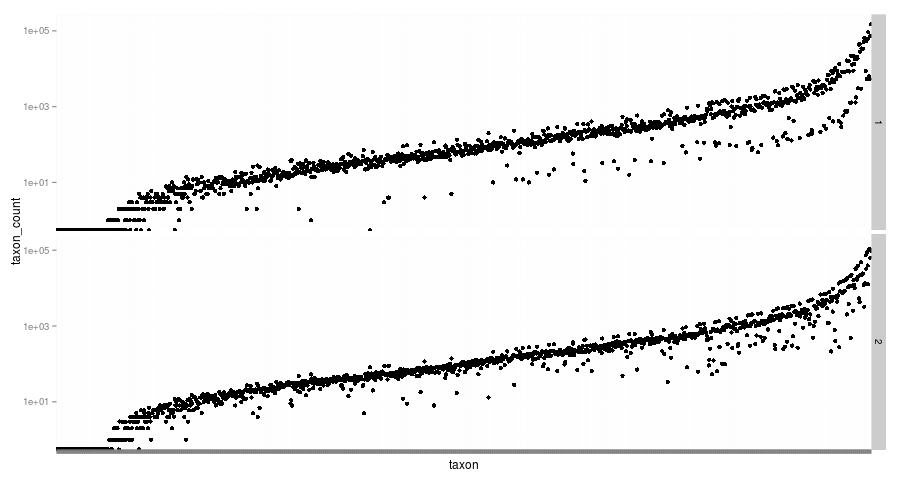

In [735]:
%%R -w 900

tbl.taxon.sum = tbl.sub %>% 
    group_by(library,taxon) %>%
    summarize(taxon_count = sum(count)) #%>%
#    arrange(taxon_count)

tbl.taxon.sum$taxon = reorder(tbl.taxon.sum$taxon, tbl.taxon.sum$taxon_count)

ggplot(tbl.taxon.sum, aes(taxon, taxon_count)) +
    geom_point() +
    facet_grid(library ~ . ) +
    scale_y_log10() +
    theme(
        axis.text.x = element_blank()
        )

In [736]:
%%R
# ordering taxa by total abundances
tax_order = tbl.sub %>%
    group_by(taxon) %>%
    summarize(taxon_total_abund = sum(count)) %>%
    as.data.frame

tax_order = unique(tax_order[order(tax_order$taxon_total_abund, decreasing=T),'taxon']) 

tbl.sub$taxon = factor(tbl.sub$taxon, levels=sort(unique(tbl.sub$taxon), decreasing=T))
tbl.sub$taxon_group = factor(tbl.sub$taxon, levels=tax_order)

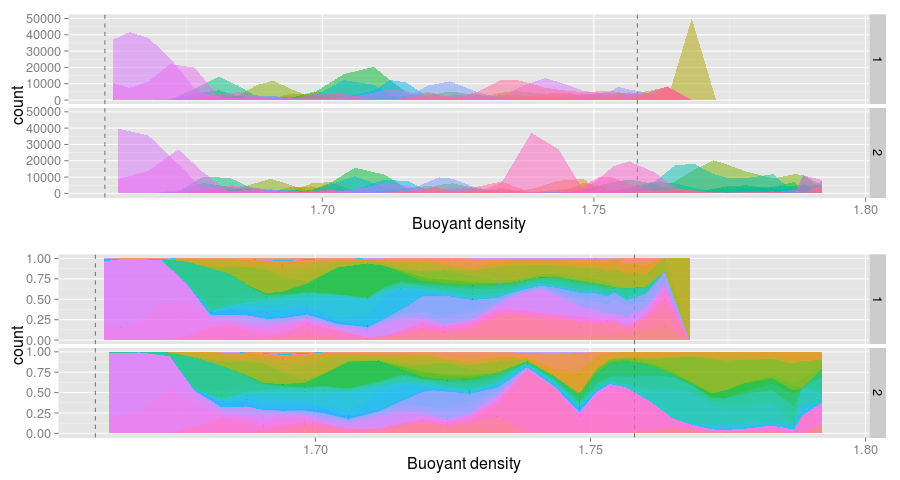

In [737]:
%%R -w 900
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

## plotting
p = ggplot(tbl.sub, aes(BD_mean, count, fill=taxon, group=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p1 = p + geom_area(stat='identity', alpha=0.5, position='dodge') 
p2 = p + geom_area(stat='identity', alpha=0.8, position='fill') 

grid.arrange(p1, p2, ncol=1)


Call:
lm(formula = BD_range ~ log(total_abund), data = tbl.sub.bdr)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.041915 -0.007014 -0.002302  0.003739  0.053534 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.0047970  0.0008963   5.352 1.05e-07 ***
log(total_abund) 0.0058900  0.0001532  38.434  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0114 on 1132 degrees of freedom
Multiple R-squared:  0.5661,	Adjusted R-squared:  0.5658 
F-statistic:  1477 on 1 and 1132 DF,  p-value: < 2.2e-16



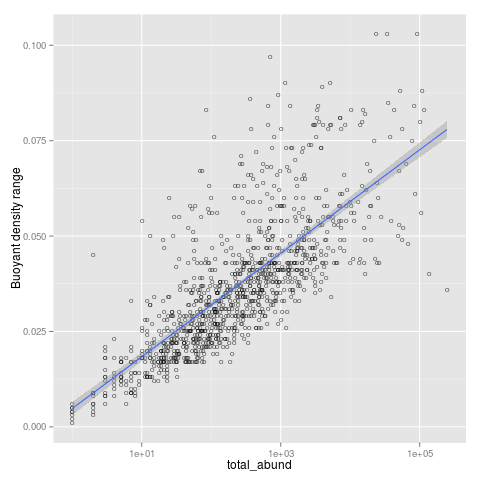

In [738]:
%%R

tbl.sub.bdr = tbl.sub %>%
    group_by(taxon) %>%
    filter(count > 0) %>%
    summarize(BD_range = max(BD_max) - min(BD_min),
              total_abund = sum(count))  

# linear regression
res = lm(BD_range ~ log(total_abund), tbl.sub.bdr)
print(summary(res))

# plotting 
ggplot(tbl.sub.bdr, aes(total_abund, BD_range)) +
    geom_point(alpha=0.75, shape='O') +
    labs(y='Buoyant density range') +
    geom_smooth(method='lm') +
    scale_x_log10()

# Deseq2 analysis

In [739]:
%%R
rm(list=ls())
library(DESeq2)
library(ggplot2)
library(phyloseq)
library(dplyr)
library(tidyr)
library(vegan)

## Data import

* Creating a phyloseq object

In [740]:
!cd $workDir; \
    SIPSim OTU_wideLong -w \
    OTU-n1-logn_skewN90-25-n5-nS_A2e9_sub50k.txt \
    > OTU-n1-logn_skewN90-25-n5-nS_A2e9_sub50k_w.txt

In [741]:
%%R -i workDir

tbl.otu = read.delim('OTU-n1-logn_skewN90-25-n5-nS_A2e9_sub50k_w.txt', check.names=F)
rownames(tbl.otu) = tbl.otu$taxon
tbl.otu$taxon = NULL

print(nrow(tbl.otu))
print(ncol(tbl.otu))

[1] 1210
[1] 74


In [742]:
%%R

mean_BD = function(BD_min, BD_max){
    if(is.infinite(BD_min)){
        return(BD_max)
        } else
    if(is.infinite(BD_max)){
        return(BD_min)
        } else {
        return(mean(BD_min, BD_max))
        }
    }

In [743]:
%%R
# Making sample_data table
sampleData = data.frame('samples'=colnames(tbl.otu)) %>%
    filter(samples != 'taxon') %>%
    separate(samples, c('library', 'BD_range'), sep='__', remove=F) %>%
    select(-library) %>%
    separate(samples, c('library','BD_min','BD_max'), sep='[_-]+', remove=F) %>%
    mutate( BD_min = as.numeric(BD_min),
            BD_max = as.numeric(BD_max),
            BD_mean = mean_BD(BD_min, BD_max)
          )

rownames(sampleData) = sampleData$samples
sampleData$samples = NULL
head(sampleData)

               library BD_min BD_max    BD_range BD_mean
1__-inf-1.660        1    Inf  1.660  -inf-1.660   1.660
1__1.660-1.663       1  1.660  1.663 1.660-1.663   1.663
1__1.663-1.666       1  1.663  1.666 1.663-1.666   1.666
1__1.666-1.670       1  1.666  1.670 1.666-1.670   1.670
1__1.670-1.674       1  1.670  1.674 1.670-1.674   1.674
1__1.674-1.679       1  1.674  1.679 1.674-1.679   1.679


In [744]:
%%R
# making phyloseq object

physeq = phyloseq(otu_table(tbl.otu, taxa_are_rows=T), sample_data(sampleData))
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1210 taxa and 74 samples ]
sample_data() Sample Data:       [ 74 samples by 5 sample variables ]


In [745]:
%%R
# filtering samples with no taxa

physeq = prune_samples(sampleSums(physeq) > 0, physeq)
print(summary(sampleSums(physeq)))
message('\n')
physeq

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  50000   50000   50000   50000   50000   50000 


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1210 taxa and 68 samples ]
sample_data() Sample Data:       [ 68 samples by 5 sample variables ]


### Plotting community diversity

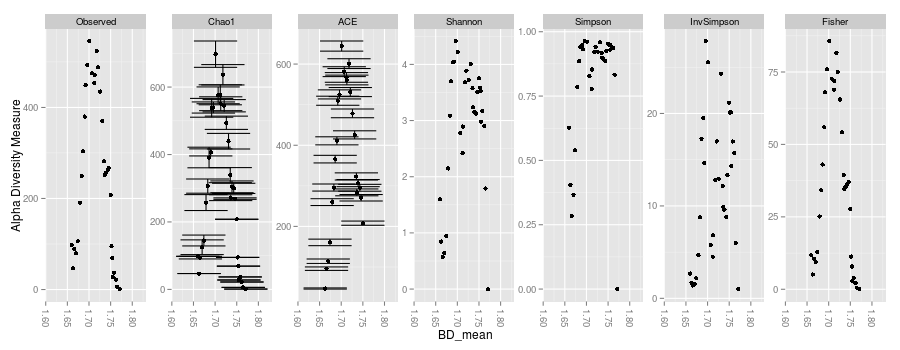

In [746]:
%%R -w 900 -h 350
# richness

physeq.L1 = subset_samples(physeq, library==1)
plot_richness(physeq.L1, x='BD_mean')

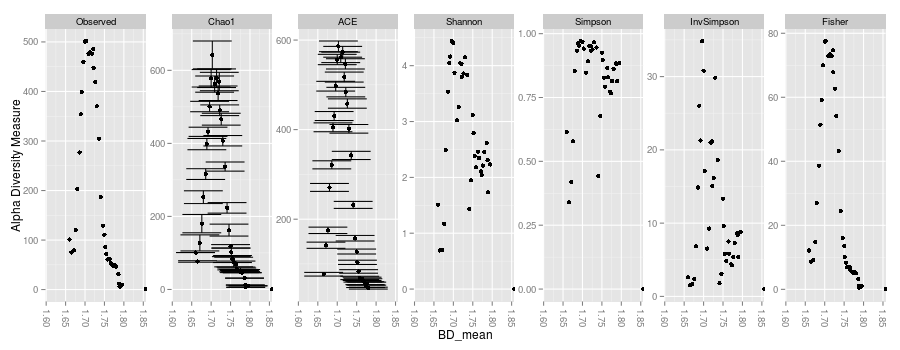

In [747]:
%%R -w 900 -h 350
physeq.L2 = subset_samples(physeq, library==2)
plot_richness(physeq.L2, x='BD_mean')

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1021193 
Run 1 stress 0.0766199 
... New best solution
... procrustes: rmse 0.06017001  max resid 0.3571429 
Run 2 stress 0.08346664 
Run 3 stress 0.07661787 
... New best solution
... procrustes: rmse 0.0008444546  max resid 0.004629016 
*** Solution reached


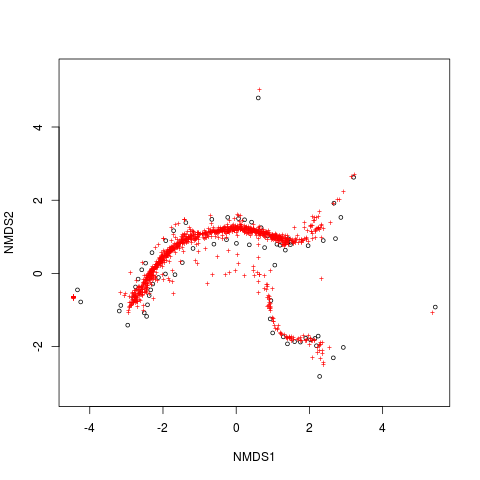

In [748]:
%%R
ord.nmds.bray = ordinate(physeq, 'NMDS', 'bray')
plot(ord.nmds.bray)

## Pruning to just 'heavy' fractions

### Finding heavy fraction interval where >=1 taxon is found in all fractions

In [795]:
%%R -w 450

# BD range (starting range that will be trimmed to range of overlapping                          
BD_min_cut = 1.70
BD_max_cut = 1.75   

physeq.m = psmelt(physeq)


## trimming to just BD-range
physeq.m = physeq.m %>%
    filter(Abundance > 0, BD_min >= BD_min_cut, BD_max <= BD_max_cut) %>%
    group_by(library, OTU) %>%
    summarize( OTU_BD_min = min(BD_min),
               OTU_BD_mean = mean(BD_mean),
               OTU_BD_max = max(BD_max),
               OTU_BD_range = OTU_BD_max - OTU_BD_min)

## finding taxon that spans the greatest amount of the range
taxa.oi = physeq.m %>% filter(OTU_BD_range == max(OTU_BD_range)) %>% as.data.frame


#tbl.otu[taxa.oi$OTU,]
#physeq.prn.m$OTU = reorder(physeq.prn.m$OTU, physeq.prn.m$OTU_BD_range)


#ggplot(physeq.m, aes(library, OTU_BD_range)) +
#    geom_boxplot()

                                                       1__-inf-1.660
Acidiphilium_cryptum_JF-5                                          0
Advenella_kashmirensis_WT001                                       0
Aeromonas_hydrophila_AL09-71                                       0
Alcanivorax_dieselolei_B5                                          0
Arcanobacterium_haemolyticum_DSM_20595                             0
Bifidobacterium_longum_DJO10A                                      0
Candidatus_Symbiobacter_mobilis_CR                                 0
Cellvibrio_japonicus_Ueda107                                       0
Corynebacterium_jeikeium_K411                                      0
Corynebacterium_vitaeruminis_DSM_20294                             0
Dechlorosoma_suillum_PS                                            0
Deinococcus_peraridilitoris_DSM_19664                              0
Desulfovibrio_vulgaris_str_Miyazaki_F                              0
Enterobacter_cloacae_subsp_cloacae

In [798]:
%%R

deseq_prune = function(physeq.obj, BD_min, BD_max, occur_thresh=0.25, min_taxa=10) {
    physeq.sd = sample_data(physeq.obj)
    p = prune_samples((physeq.sd$BD_mean >= BD_min)&
                      (physeq.sd$BD_mean <= BD_max), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > (occur_thresh * length(x)), TRUE)
    p.thresh = prune_samples(sampleSums(p.thresh) >= min_taxa, p.thresh)
    return(p.thresh)
}
 
                           
# BD range                           
BD_min_cut = 1.71
BD_max_cut = 1.75                         

                           
physeq.prn = deseq_prune(physeq, BD_min=BD_min_cut, BD_max=BD_max_cut, occur_thresh=0.1) 
physeq.prn

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 729 taxa and 22 samples ]
sample_data() Sample Data:       [ 22 samples by 5 sample variables ]


### Plotting BD range of each taxon

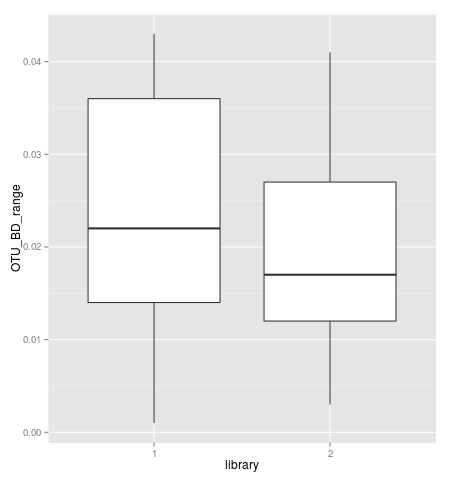

In [799]:
%%R -w 450
physeq.prn.m = psmelt(physeq.prn)


physeq.prn.m = physeq.prn.m %>%
    filter(Abundance > 0) %>%
    group_by(library, OTU) %>%
    summarize( OTU_BD_min = min(BD_min),
               OTU_BD_mean = mean(BD_mean),
               OTU_BD_max = max(BD_max),
               OTU_BD_range = OTU_BD_max - OTU_BD_min)


physeq.prn.m$OTU = reorder(physeq.prn.m$OTU, physeq.prn.m$OTU_BD_range)


ggplot(physeq.prn.m, aes(library, OTU_BD_range)) +
    geom_boxplot()

## Plotting diversity

Square root transformation
Wisconsin double standardization
Run 0 stress 0.04244514 
Run 1 stress 0.04244487 
... New best solution
... procrustes: rmse 0.0002338547  max resid 0.0007962503 
*** Solution reached


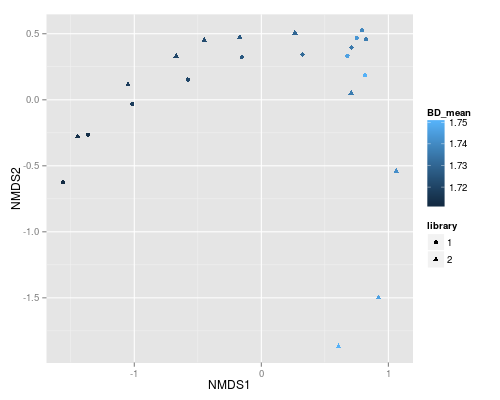

In [800]:
%%R -w 500 -h 400
tmp = sample_data(physeq.prn) 
tmp$BD_mean_char = as.character(tmp$BD_mean)
sample_data(physeq.prn) = tmp

ord.nmds.bray = ordinate(physeq.prn, 'NMDS', 'bray')
plot_ordination(physeq.prn, ord.nmds.bray, color='BD_mean', shape='library')

## Deseq2

In [801]:
%%R

dds = phyloseq_to_deseq2(physeq.prn, ~library)
dds$library = relevel(dds$library, 1)
dds = DESeq(dds)
res = results(dds)
#res

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 243 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [802]:
%%R

theta = 0.5
beta = res$log2FoldChange
betaSE = res$lfcSE
res$p = pnorm(beta, theta, betaSE, lower.tail = FALSE)

res

log2 fold change (MAP): library 2 vs 1 
Wald test p-value: library 2 vs 1 
DataFrame with 729 rows and 7 columns
                                                         baseMean
                                                        <numeric>
Acetobacter_pasteurianus_IFO_3283-12                    41.241563
Acetohalobium_arabaticum_DSM_5501                       46.485309
Acidaminococcus_fermentans_DSM_20731                    46.008183
Acidaminococcus_intestini_RyC-MR95                       3.016466
Acidimicrobium_ferrooxidans_DSM_10331                    2.209651
...                                                           ...
_Bacillus_selenitireducens_MLS10                         2.503718
_Cellvibrio_gilvus_ATCC_13127                           21.974245
_Clostridium_clariflavum_DSM_19732                       9.129301
_Clostridium_saccharolyticum_WM1                      4169.889718
uncultured_Termite_group_1_bacterium_phylotype_Rs-D17    4.231206
                             

In [807]:
%%R

res.tbl = res %>% as.data.frame %>%
    mutate(OTU = rownames(res))

res.tbl %>% filter(padj < 0.05) %>% nrow

[1] 56


## Desq2 results: assessing accuracy/specificity

In [718]:
# TP = incorp/incorp
# FP = incorp/no-incorp
# TN = no-incorp/no-incorp
# FN = no-incorp/incorp

### Getting taxa that have incorporated

In [808]:
%%R
# plotting incorp
tbl.incorp = read.delim('incorp-n2-logn.txt', sep='\t')

## quanifying number of taxa 
n_taxa = tbl.incorp %>% filter(library == 2) %>% distinct(taxon_name) %>% nrow 
message('Number of taxa: ', n_taxa)
n_taxa_mu1 = tbl.incorp %>% filter(library == 2, param == 'mu', param_value > 1) %>% nrow 
message('Number of taxa with mu > 1: ', n_taxa_mu1)
message('Percent taxa with mu > 1: ', round(n_taxa_mu1 / n_taxa * 100, digits=1), '%')

## taxa that incorporated
taxa.incorp = tbl.incorp %>% 
    filter(library == 2, param == 'mu', param_value > 1) %>% 
    distinct(taxon_name) 

Number of taxa: 1210
Number of taxa with mu > 1: 123
Percent taxa with mu > 1: 10.2%


In [809]:
%%R
taxa.incorp

    library                                                        taxon_name
1         2                                    Methylobacillus_flagellatus_KT
2         2            Cardinium_endosymbiont_cEper1_of_Encarsia_pergandiella
3         2                                     Thiocystis_violascens_DSM_198
4         2                   Campylobacter_fetus_subsp_venerealis_cfvi03_293
5         2                Blattabacterium_sp_Periplaneta_americana_str_BPLAN
6         2                                     Salinispora_arenicola_CNS-205
7         2                                 Treponema_brennaborense_DSM_12168
8         2 Neorhizobium_galegae_bv_officinalis_bv_officinalis_str_HAMBI_1141
9         2                       Aggregatibacter_actinomycetemcomitans_D7S-1
10        2                            Syntrophothermus_lipocalidus_DSM_12680
11        2                                  Gardnerella_vaginalis_ATCC_14019
12        2                                 Parvularcula_bermude

In [821]:
%%R
# intersection of incorporated taxa

p_val_cut = 0.05

tp = res.tbl %>% filter(padj < p_val_cut,
                   OTU %in% taxa.incorp$taxon_name) %>% nrow

fp = res.tbl %>% filter(padj < p_val_cut,
                        ! OTU %in% taxa.incorp$taxon_name) %>% nrow

tn = res.tbl %>% filter(padj >= p_val_cut,
                   ! OTU %in% taxa.incorp$taxon_name) %>% nrow

fn = res.tbl %>% filter(padj >= p_val_cut,
                         OTU %in% taxa.incorp$taxon_name) %>% nrow

message('tp: ', tp, '\n',
        'fp: ', fp, '\n',
        'tn: ', tn, '\n',
        'fn: ', fn, '\n')

message('sensitivity: ', round(tp / (tp + fn), digits=3))
message('specificity: ', round(tn / (tn + fp), digits=3))

tp: 44
fp: 12
tn: 606
fn: 67

sensitivity: 0.396
specificity: 0.981


# sandbox

In [822]:
%%R
library(caret)


Attaching package: ‘caret’

The following object is masked from ‘package:vegan’:

    tolerance



In [854]:
%%R -i workDir

# loading file
inFiles = c('OTU-n1-logn_skewN90-25-n5-nS_A2e9.txt')

inFiles = sapply(inFiles, function(x){
            paste(c(workDir, x), collapse='/')
    })

tbls = list()
for (fileName in names(inFiles)){
    tbls[[fileName]] = read.csv(fileName, sep='\t')
    }
tbl = do.call(rbind, tbls)
tbl$abs_abund = as.numeric(gsub('.+-nS_A|\\.txt\\.[0-9]+', '', rownames(tbl)))


mean_BD = function(BD_min, BD_max){
    if(is.infinite(BD_min)){
        return(BD_max)
        } else
    if (is.infinite(BD_max)){
        return(BD_min)
        } else {
        return(mean(BD_max - BD))
        }
    }

tbl = tbl %>% 
    filter(!grepl('inf', fractions, ignore.case=T)) %>%
    separate(fractions, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%
    filter(BD_min != 1.795) %>%
    mutate(
        BD_min = as.numeric(BD_min),
        BD_max = as.numeric(BD_max),
        BD_mean = (BD_min + BD_max) / 2
        ) %>% as.data.frame

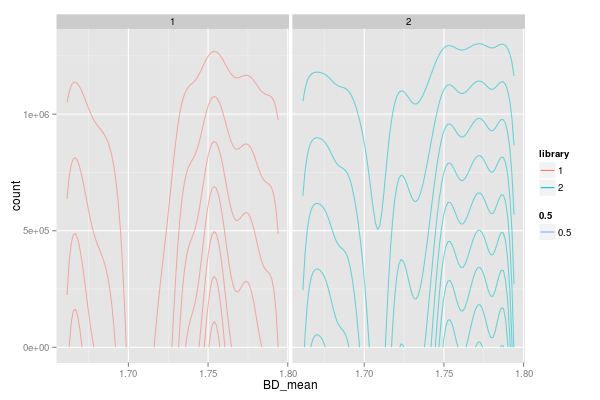

In [855]:
%%R -w 600 -h 400

tbl$library = as.character(tbl$library)
ggplot(tbl, aes(BD_mean, count, group=library, color=library, alpha=0.5))+
    stat_density2d() +
    facet_grid(. ~ library)